# Data Processing TMQ
From Teagan King and John Truesdale, updated by Katie Dagon (Dec 2022)

## Import libraries

In [1]:
import cftime
import glob
import numpy as np
import xarray as xr
import scipy.constants as sc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Set up Dask

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='10GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35787 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/35787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/35787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:35582,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/35787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Calculating TMQ

3 hrly TMQ can be calculated from the h4 3hourly average Q. \
Previously used NCL for this: `/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/TMQ.ncl` \
You will need to use PS from the h3 files. \
The script calculates the pressure in each model level and then multiplies by Q and divides by gravity to the mass of in each level. Then it sums all the levels to get the TMQ field.

### Read in files and get pressure values

In [4]:
# cat /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/tmq.ncl

In [4]:
datadir = '/glade/scratch/tking/cgnet/'
qfile_format = '*.Q.*.nc' # Q files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4, 3hourly avg from 2080-2085 (Where are 2086-2100?)
psfile_format = '*.PS.*.nc'  # PS files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3, 3hourly avg from 2080-2100

qfilenames = sorted(glob.glob(datadir+qfile_format))  # sort to retain file order & ensure q and ps files match
psfilenames = sorted(glob.glob(datadir+psfile_format))

In [5]:
qfilenames

['/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2080010100Z-2080123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2081010100Z-2081123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2082010100Z-2082123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2083010100Z-2083123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2084010100Z-2084123118Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.Q.2085010100Z-2085123118Z.nc']

In [6]:
psfilenames

['/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2080010100Z-2080123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2081010100Z-2081123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2082010100Z-2082123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2083010100Z-2083123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2084010100Z-2084123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2085010100Z-2085123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2088010100Z-2088123121Z.nc',
 '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2089010100Z-2089123121Z.nc',


In [7]:
# make new .nc files but replace Q with TMQ
tmqnew_files = []
for filename in qfilenames:
    tmqnew_files.append((filename.replace('.Q.', '.TMQ.')).split('/')[-1])

In [8]:
tmqnew_files

['b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2080010100Z-2080123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2081010100Z-2081123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2082010100Z-2082123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2083010100Z-2083123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2084010100Z-2084123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2085010100Z-2085123118Z.nc']

### Test with the first file (year 2080)

In [9]:
qfile1 = xr.open_dataset(qfilenames[0], chunks={"time": 100, "ncol": 10000}) # adjusting chunks for ~100mb size chunks
psfile1 = xr.open_dataset(psfilenames[0], chunks={"time": 100, "ncol": 10000}) # using the same chunk size for consistency

file_1_Q = qfile1['Q'] # Q at each level
file_1_PS = psfile1['PS'] # surface pressure

pref = psfile1['P0'] # reference pressure
plev = psfile1.lev

In [10]:
file_1_Q

<xarray.DataArray 'Q' (time: 2920, lev: 30, ncol: 777602)>
dask.array<open_dataset-9217d6565837b6e7875b46d1686397f2Q, shape=(2920, 30, 777602), dtype=float32, chunksize=(100, 30, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [11]:
file_1_PS

<xarray.DataArray 'PS' (time: 2920, ncol: 777602)>
dask.array<open_dataset-0cffb7fdf9ecb00ead16efb2ec7d04e8PS, shape=(2920, 777602), dtype=float32, chunksize=(100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

In [12]:
pref.values

array(100000.)

### Get hybrid level coefficients

In [13]:
psfile1['hyai']

<xarray.DataArray 'hyai' (ilev: 31)>
dask.array<open_dataset-0cffb7fdf9ecb00ead16efb2ec7d04e8hyai, shape=(31,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid A coefficient at layer interfaces

In [14]:
psfile1['hybi']

<xarray.DataArray 'hybi' (ilev: 31)>
dask.array<open_dataset-0cffb7fdf9ecb00ead16efb2ec7d04e8hybi, shape=(31,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid B coefficient at layer interfaces

### Calculate pressure at each level

In [15]:
plev3d=(psfile1['hyai']*pref + psfile1['hybi']*file_1_PS)
plev3d

<xarray.DataArray (ilev: 31, time: 2920, ncol: 777602)>
dask.array<add, shape=(31, 2920, 777602), dtype=float64, chunksize=(31, 100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

### Calculate delta pressure at each level

In [16]:
dp3d=(plev3d[1:,:,:].drop_vars('ilev')-plev3d[:-1,:,:].drop_vars('ilev'))
#dp3d

dp3dlev=dp3d.rename({'ilev': 'lev'}) # rename level
dp3dlev

<xarray.DataArray (lev: 30, time: 2920, ncol: 777602)>
dask.array<sub, shape=(30, 2920, 777602), dtype=float64, chunksize=(30, 100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: lev, ncol

In [17]:
# assign coordinate to dimension
dp3dlev = dp3dlev.assign_coords(coords={'lev' : plev})
dp3dlev

<xarray.DataArray (lev: 30, time: 2920, ncol: 777602)>
dask.array<sub, shape=(30, 2920, 777602), dtype=float64, chunksize=(30, 100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Dimensions without coordinates: ncol

In [18]:
# transpose to match Q
dp3dlevT = dp3dlev.transpose('time', 'lev', 'ncol')
dp3dlevT

<xarray.DataArray (time: 2920, lev: 30, ncol: 777602)>
dask.array<transpose, shape=(2920, 30, 777602), dtype=float64, chunksize=(100, 30, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Dimensions without coordinates: ncol

In [19]:
# double check Q file
file_1_Q

<xarray.DataArray 'Q' (time: 2920, lev: 30, ncol: 777602)>
dask.array<open_dataset-9217d6565837b6e7875b46d1686397f2Q, shape=(2920, 30, 777602), dtype=float32, chunksize=(100, 30, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

### Multiply delta pressure by Q and divide by gravity to get mass of each level

In [20]:
gravity=sc.g
gravity

9.80665

In [21]:
Qdp = file_1_Q * dp3dlevT / gravity
Qdp

<xarray.DataArray (time: 2920, lev: 30, ncol: 777602)>
dask.array<truediv, shape=(2920, 30, 777602), dtype=float64, chunksize=(100, 30, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

### Sum over levels to get TMQ

In [22]:
tmq = Qdp.sum(dim='lev')
tmq

<xarray.DataArray (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

In [ ]:
# quick unit check
# pressure (Pa) = kg m^−1 s^−2
# gravity = m s^-2
# pressure / gravity = kg m^-2

## Assign some attribues to TMQ
### TO DO: add attributes/metadata to be consistent with CESM netcdf conventions

In [24]:
tmq = tmq.assign_attrs({'long_name' : 'Total (vertically integrated) precipitable water',
                  'units' : 'kg/m2'})
tmq.name="TMQ"
tmq

<xarray.DataArray 'TMQ' (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    long_name:  Total (vertically integrated) precipitable water
    units:      kg/m2

## Compute TMQ before writing out
Be sure to have enough memory available: in hub and dask workers

### TO DO: This is slow - how to speed up?
* Rechunk TMQ so the chunk sizes are smaller?
* Increase number of workers?
* Total memory for 1 year of processing was about ~30 GB

In [25]:
tmq = tmq.compute()

## Save out TMQ

This is relatively quick once TMQ has been loaded into memory

In [26]:
%%time
tmq.to_netcdf('/glade/scratch/kdagon/cgnet/TMQ_2080.nc')

CPU times: user 1.3 s, sys: 20.1 s, total: 21.4 s
Wall time: 1min 53s


## Regrid the file using `ncremap`

What are the memory needs for running ncremap in a notebook cell?

In [27]:
%%bash
module load nco/4.7.9
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/kdagon/cgnet/TMQ_2080.nc -o /glade/scratch/kdagon/cgnet/TMQ_2080_regrid.nc

Input #00: /glade/scratch/kdagon/cgnet/TMQ_2080.nc
Map/Wgt  : /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc
Regridded: /glade/scratch/kdagon/cgnet/TMQ_2080_regrid.nc


ncks: INFO Reducing user-requested thread number = 2 to maximum thread number allowed = 1
ncks: WARNING NC_DOUBLE version of "_FillValue" attribute for TMQ fails isfinite(), value is NaN, which can cause unpredictable results.
HINT: If arithmetic results (e.g., from regridding) fails or values seem weird, retry after first converting _FillValue to normal number with, e.g., "ncatted -a _FillValue,TMQ,m,f,1.0e36 in.nc out.nc"


In [35]:
# Read back in for plotting
fn=('/glade/scratch/kdagon/cgnet/TMQ_2080_regrid.nc')
dstmq=xr.open_dataset(fn, chunks={"time": 20}) # adjust for chunk size ~100MB

In [36]:
dstmq.TMQ

<xarray.DataArray 'TMQ' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-da385547868869d36dd6da457461506eTMQ, shape=(2920, 768, 1152), dtype=float64, chunksize=(20, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    cell_measures:  area: area

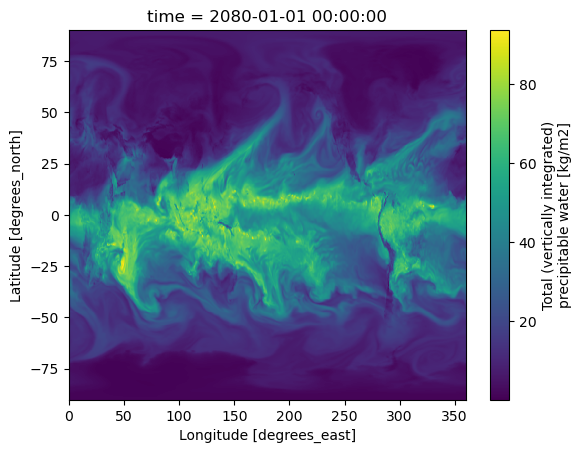

In [38]:
# Quick plot of first time index
dstmq['TMQ'].isel(time=0).plot();

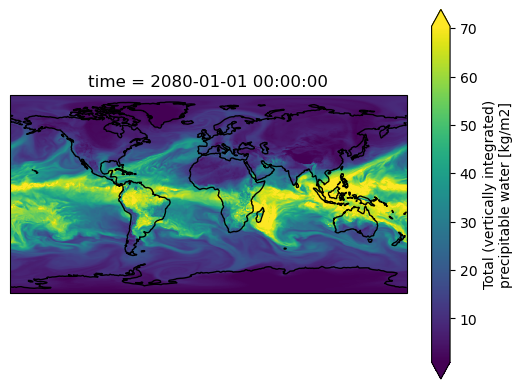

In [42]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
dstmq['TMQ'].isel(time=0).plot(transform=ccrs.PlateCarree(),robust=True);

## Some notes on writing netcdf files

In [ ]:
# from netCDF4 import Dataset
# import os
# from datetime import datetime
# import numpy as np

# # make a netcdf file

# # CHANGE TO WITHIN FOR STATEMENT WITH ALL FILES ONCE WORKING ON MULTIPLE!
# filename_to_create = '/glade/scratch/tking/cgnet/tmq.nc'
# if os.path.exists(filename_to_create):
#     print('warning, path exists already! not overwriting')
# else:
#     tmq_ncfile = Dataset('/glade/scratch/tking/cgnet/tmq.nc', #+tmqnew_files[0], 
#                      mode='w', format='NETCDF4_CLASSIC')
#     ### MAY NEED TO CHANGE THESE TO TIME 3 NCOL 777602 AND REGRID...
#     # lat_dim = tmq_ncfile.createDimension('lat', 73)     # latitude axis
#     # lon_dim = tmq_ncfile.createDimension('lon', 144)    # longitude axis
#     # time_dim = tmq_ncfile.createDimension('time', None) # unlimited axis (can be appended to).
#     # lev_dim = tmq_ncfile.createDimension('lev', 31)

#     ncol_dim = tmq_ncfile.createDimension('ncol', 777602)
#     time_dim = tmq_ncfile.createDimension('time', 3)
    
#     # other global attributes needed for netcdf files:
#     # data_title = "3-hr averaged/vertically integrated/CESM Water Vapor"
#     # data_summary = "Create input for ClimateNet application, Poisson Fill for NaNs"
#     # data_creator = "Teagan King, tking@ucar.edu"
#     # cesm_contact = "Teagan King, tking@ucar.edu"
#     # data_script = "jupyter notebook at /glade/u/home/tking/cgnet/Data_Processing.ipynb"
#     # source_file =  qfilenames[0] + psfilenames[0]
#     # conventions = "CF 1.0"
#     # creation_date = datetime.today().strftime('%Y-%m-%d')

#     # actually add this info into file...
#     # tmq_ncfile.title = data_title
#     # tmq_ncfile.summary = data_summary
#     # tmq_ncfile.creator = data_creator
#     # tmq_ncfile.contact = cesm_contact
#     # tmq_ncfile.script = data_script
#     # # tmq_ncfile.source = source_file
#     # tmq_ncfile.conventions = conventions
#     # tmq_ncfile.creation_date = creation_date
    
#     # add data to netcdf file under 'TMQ'
#     tmq_var = tmq_ncfile.createVariable('TMQ',np.float64,('time','ncol')) # unlimited dimension is leftmost
#     # tmq_var.units = 'kg/m2'
#     # tmq_var.long_name = 'Total (vertically integrated) precipitable water'

#     tmq_var[:,:] = tmq